In [1]:
# PART 1

import pydicom
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import itk
import SimpleITK as sitk
from scipy import ndimage
from scipy.ndimage import zoom
import nrrd
from medpy.filter.smoothing import anisotropic_diffusion
import cv2
import os

In [2]:
# add .dcm to files
for imgs in glob.glob("*"):
    
    if 'IMG' in imgs:
        os.rename(imgs, imgs+'.dcm')

In [3]:
# load the DICOM files
files = []
print('glob: {}'.format("*.dcm"))
for fname in glob.glob("*.dcm", recursive=False):
    #print("loading: {}".format(fname))
    ds=pydicom.filereader.dcmread(fname)
    if ds.SeriesNumber==5 and ds.pixel_array.shape==(512,512):
        files.append(pydicom.read_file(fname))
        #print(fname)

print("file count: {}".format(len(files)))

glob: *.dcm
file count: 146


In [4]:
# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'InstanceNumber'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))

skipped, no SliceLocation: 0


In [5]:
# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.InstanceNumber)
print(len(slices))

146


In [6]:
# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)
print(img3d.shape)

(512, 512, 146)


In [7]:
# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

#reverse order if necesary    
#img3d = img3d[::-1,:,:]

Slice Thickness: 1.000000
Pixel Spacing (row, col): (0.464844, 0.464844) 
(512, 512, 146)
0.0
4095.0


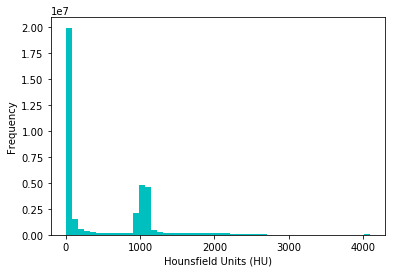

In [8]:
# although we have each individual slices, it is not immediately clear how thick each slice is. Therefore:
print("Slice Thickness: %f" % slices[0].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) " % (slices[0].PixelSpacing[0], slices[0].PixelSpacing[1]))    

print(img3d.shape)     

print(np.amin(img3d))
print(np.amax(img3d))
      
# histogram of voxels
plt.figure()
plt.hist(img3d.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

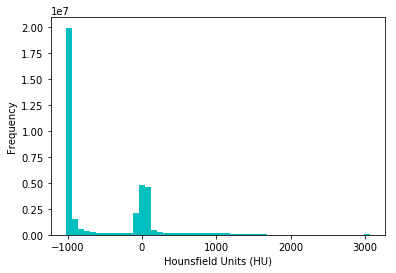

In [9]:
# Part 2

#if necessary, convert from CT values to HU units

img3d=img3d*1-1024
    
# histogram of voxels
plt.figure()
plt.hist(img3d.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [10]:
# PART 3

#If necessary, cut geometry
img3d=img3d[:,:,0:400]
print(img3d.shape)

(512, 512, 400)


In [10]:
# PART 4
# kernel for convolution filter
k = np.array([[-1,-1,-1],[-1,10,-1],[-1,-1,-1]])

# initialisation of output file
CONV_and_GAD_filter=np.zeros((img3d.shape[0],img3d.shape[1],img3d.shape[2]))

# apply Convolution filter and Gradient Anisotropic Diffusion filter to every slice of the CT data
for i in range(img3d.shape[0]):
    slice_conv_filter=ndimage.convolve(img3d[i,:,:], k, mode='constant', cval=0)
    #Convert NP array to SITK format
    slice_GAD = sitk.GetImageFromArray(slice_conv_filter)
    #Set up GAD filter and its parameters
    GAD = sitk.GradientAnisotropicDiffusionImageFilter()
    GAD.SetNumberOfIterations(8)
    GAD.SetTimeStep(0.0625)
    GAD.SetConductanceParameter(5.0)
    #Execute GAD filter
    filtered_slice = GAD.Execute(slice_GAD)
    #Convert back to NP array
    CONV_and_GAD_filter[i,:,:]=sitk.GetArrayFromImage(filtered_slice)

# Change x and y for 3D Slicer
img3d_a = np.empty((img3d.shape[1],img3d.shape[0],img3d.shape[2]))
img3d_a = np.transpose(img3d, (1, 0, 2))

CONV_and_GAD_filter_a = np.empty((img3d.shape[1],img3d.shape[0],img3d.shape[2]))
CONV_and_GAD_filter_a = np.transpose(CONV_and_GAD_filter, (1, 0, 2))

# write to .NRRD file
nrrd.write('CT_000043_01.nrrd', CONV_and_GAD_filter)
nrrd.write('CT_000043_00.nrrd', img3d)

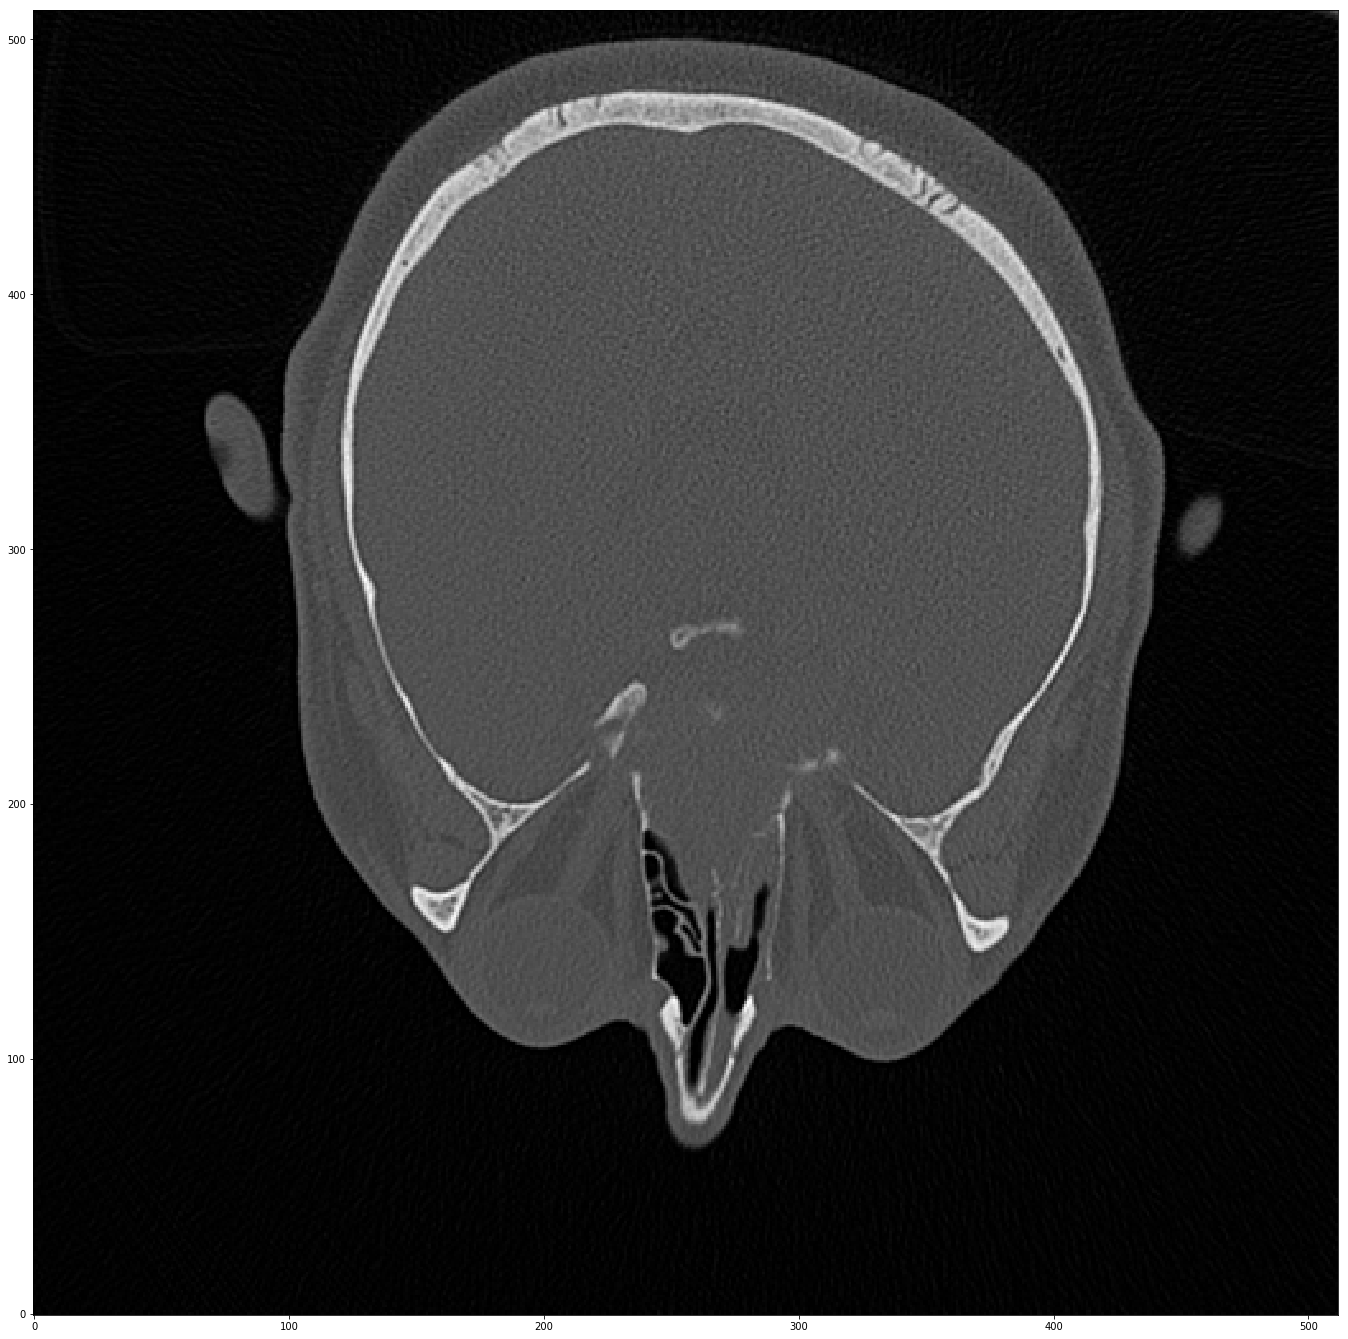

In [11]:
# PART 5
#View test slices
test_slice_zoom=img3d[:,:,50]
#test_slice_reversed_zoom=reversed_img3d[:,:,50]

plt.figure(figsize=(30,24))

#a1 = plt.subplot(1, 2, 1)
plt.imshow(test_slice_zoom,cmap='gray', origin='lower')

#a2 = plt.subplot(1, 2, 2)
#plt.imshow(test_slice_reversed_zoom,cmap='gray',origin='lower')

[  416.   407.   390.   389.   422.   444.   456.   479.   513.   531.
   539.   546.   569.   590.   584.   560.   571.   603.   617.   618.
   615.   604.   583.   552.   519.   491.   466.   468.   505.   543.
   565.   611.   690.   757.   805.   854.   895.   944.   973.   935.
   832.   746.   696.   667.   644.   624.   576.   488.   358.   239.
   158.    94.    22.   -58.  -164.  -314.  -492.  -647.  -754.  -822.
  -864.  -893.  -922.  -961.  -968.  -942.  -900.  -884.  -899.  -934.
  -947.  -949.  -942.  -935.  -941.  -968.  -994. -1007.  -999.  -990.
  -966.  -944.  -938.  -952.  -973.  -994. -1003.  -996.  -962.  -917.
  -898.  -908.  -919.  -921.  -928.  -931.  -928.  -928.  -951.  -953.
  -946.  -961.  -943.  -814.  -604.  -351.   -60.   255.   539.   733.
   787.   706.   556.   419.   307.   200.    97.    33.     7.     0.
     5.    13.    30.    47.    29.   -34.   -84.   -95.   -83.   -79.
   -81.   -84.   -72.   -66.   -68.   -55.   -18.    -3.   -13.   -39.
   -43

<Figure size 432x288 with 0 Axes>

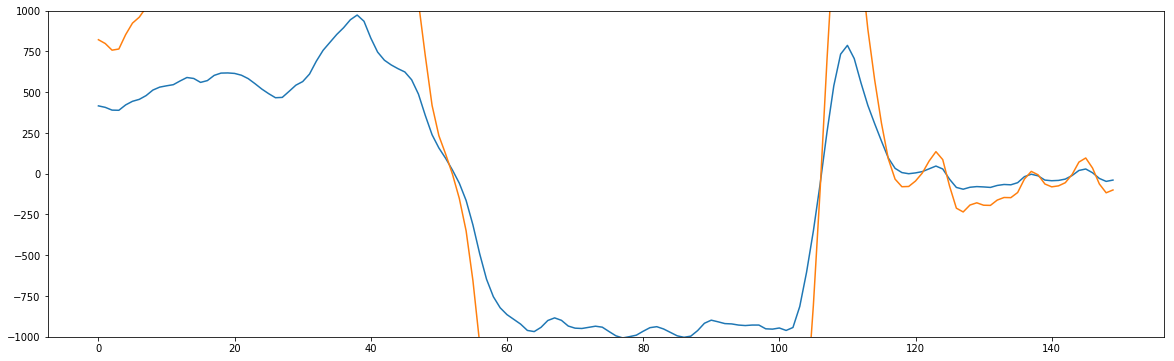

In [13]:
# Part 6
# view line plots in test slices from PART 3
x=np.arange(150)

line_raw=test_slice_zoom[20,:]
line_SITK=test_slice_SITK_zoom[20,:]

plt.figure()
plt.figure(figsize=(20,6))
plt.ylim((-1000, 1000))
plt.plot(x, line_raw)
plt.plot(x, line_SITK)

print(line_raw)